In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys() :
  print('User Uploaded file "{name}" with length {length} bytes'.format(name = fn, length= len(uploaded[fn])))


!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User Uploaded file "kaggle.json" with length 64 bytes


In [2]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.32G/1.33G [00:14<00:00, 192MB/s]
100% 1.33G/1.33G [00:14<00:00, 95.9MB/s]


In [3]:
from zipfile import ZipFile
file_name = "/content/celeba-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import hashlib
import glob
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.layers import BatchNormalization

from PIL import Image
from io import BytesIO
import base64
from IPython.core.display import display, HTML

In [5]:
BASIC_PATH = "/content/"
IMG_PATH = os.path.join(BASIC_PATH,'img_align_celeba/img_align_celeba/')
LIST_ATTR_PATH = os.path.join(BASIC_PATH,'list_attr_celeba.csv')

DF_ATTR = pd.read_csv(BASIC_PATH + 'list_attr_celeba.csv', delimiter=',')
print(IMG_PATH, LIST_ATTR_PATH)
DF_ATTR.head()

/content/img_align_celeba/img_align_celeba/ /content/list_attr_celeba.csv


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [6]:
DF_PARTITION = pd.read_csv(BASIC_PATH + 'list_eval_partition.csv')

In [7]:
DF_ATTR.set_index('image_id', inplace=True)
DF_ATTR.replace(to_replace=-1, value=0, inplace=True)
DF_ATTR.shape

(202599, 40)

In [8]:
DF_PARTITION['partition'].value_counts().sort_index()

,count
partition,
0,162770
1,19867
2,19962


Contoh file duplikat:
063521.jpg
183955.jpg
130298.jpg
016733.jpg
048395.jpg
093450.jpg
193342.jpg
197573.jpg
Total file duplikat: 131


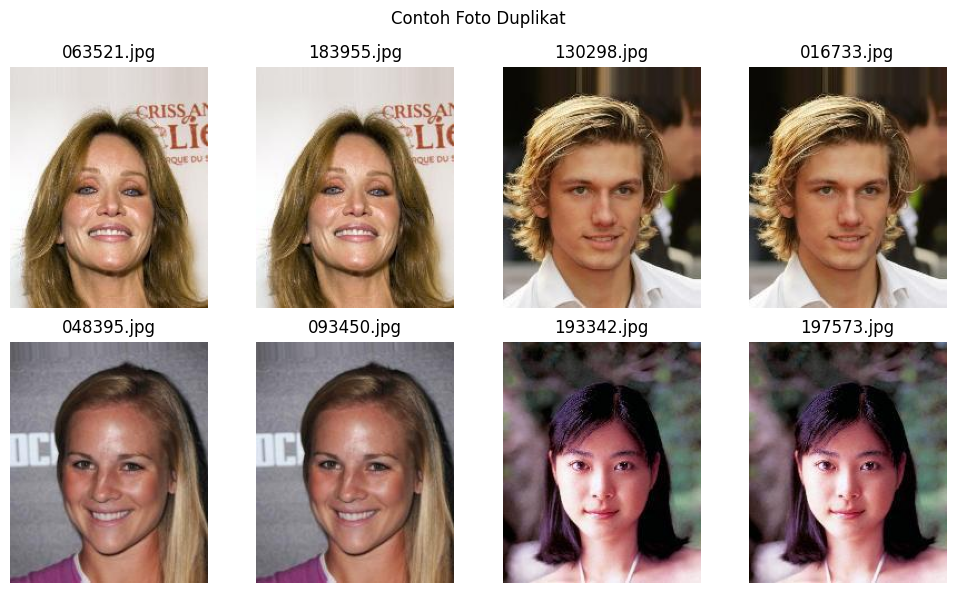

In [9]:
# Mengecek File Duplikat, Menghitung Jumlahnya dan Menampilkan 5 File Contoh

# Library yang digunakan : os dan hashlib

# Mencari semua file dengan ekstensi gambar dalam folder
image_files = [file for file in os.listdir(IMG_PATH) if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Menggunakan dictionary untuk menyimpan hash nilai dan daftar file dengan hash yang sama
duplicate_files = {}

# Memeriksa setiap file gambar
for file_name in image_files:
    file_path = os.path.join(IMG_PATH, file_name)
    with open(file_path, 'rb') as f:
        file_hash = hashlib.md5(f.read()).hexdigest()

    if file_hash not in duplicate_files:
        duplicate_files[file_hash] = [file_name]
    else:
        duplicate_files[file_hash].append(file_name)

# Menghitung total file yang duplikat
total_duplicate_files = sum(len(files) - 1 for files in duplicate_files.values())

# Menampilkan 8 contoh nama file yang duplikat
print("Contoh file duplikat:")
count = 0
for file_list in duplicate_files.values():
    if len(file_list) > 1:
        for file_name in file_list[:8]:
            count += 1
            print(file_name)
            if count == 8:
                break
    if count == 8:
        break

# Menampilkan total file yang duplikat
print(f"Total file duplikat: {total_duplicate_files}")

# Mengumpulkan 8 contoh file duplikat
duplicate_examples = []
for file_list in duplicate_files.values():
    if len(file_list) > 1:
        duplicate_examples.extend(file_list[:8])
    if len(duplicate_examples) >= 10:
        break

# Menampilkan 8 foto duplikat dengan judul sebagai nama file
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    if i < len(duplicate_examples):
        file_name = duplicate_examples[i]
        file_path = os.path.join(IMG_PATH, file_name)
        image = plt.imread(file_path)
        ax.imshow(image)
        ax.set_title(file_name)
        plt.suptitle('Contoh Foto Duplikat')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Code Modif dari Chat GPT

In [10]:
# Membuat List Nama File Foto untuk Join dengan Nama File pada File list_attribute.csv

# Library yang digunakan : glob dan pandas

# Tentukan pola nama file foto (misal: JPEG, PNG)
file_ekstensi = '*.jpg' # Ganti dengan ekstensi file gambar yang sesuai

# Tentukan direktori tempat file-file gambar berada
direktori_foto = IMG_PATH

# Mendapatkan list nama file
nama_file = glob.glob(direktori_foto + '/' + file_ekstensi)

# List nama file dijadikan dataframe
data = pd.DataFrame(nama_file, columns = ['image_id'])

# Menampilkan dataframe
data.head()

# Code Modif dari Chat GPT

,image_id
0,/content/img_align_celeba/img_align_celeba/151...
1,/content/img_align_celeba/img_align_celeba/086...
2,/content/img_align_celeba/img_align_celeba/064...
3,/content/img_align_celeba/img_align_celeba/100...
4,/content/img_align_celeba/img_align_celeba/142...


In [11]:
# Membuang karakter pertama hingga sebelum nama file
data['image_id'] = data['image_id'].str.split('\\').str[-1]
data.head()
# Note: menggunakan '\\' karena pemisah antar folder adalah '\'

# Code Modif dari Googling

,image_id
0,/content/img_align_celeba/img_align_celeba/151...
1,/content/img_align_celeba/img_align_celeba/086...
2,/content/img_align_celeba/img_align_celeba/064...
3,/content/img_align_celeba/img_align_celeba/100...
4,/content/img_align_celeba/img_align_celeba/142...


In [12]:
# Load Dataset 'list_attribute.csv'
df_attribute = pd.read_csv(LIST_ATTR_PATH)
df_attribute.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [13]:
# Cek Informasi pada DataFrame
df_attribute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

In [14]:
# Inner Join antara Objek 'data' dengan Objek 'list_attribute'
df_join = pd.merge(data, df_attribute, on = 'image_id', how = 'inner')
df_join.head()

# Code Modif dari Googling

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young


In [15]:
# Cek Jumlah Bari yang telah Join Inner
df_join.shape

(0, 41)

In [16]:
# join the partition with the attributes
DF_PARTITION.set_index('image_id', inplace=True)
DF_PARTITION = DF_PARTITION.join(DF_ATTR['Male'], how='inner')
DF_PARTITION.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [17]:
#ATTRIBUTES

# Read the attributes csv files in a dataframe format.
df = pd.read_csv(LIST_ATTR_PATH, usecols=['image_id','Male'])
df = df.sample(n=22000, random_state = 42).reset_index(drop=True)

# Reset the columns values to categorical./
df.loc[df['Male'] == -1,'Male'] = "Female"
df.loc[df['Male'] == 1,'Male'] = "Male"

# Change column names.
df.columns = ["image_id", "Gender"]

df.head(-10)

<ipython-input-17-26c86b0758e9>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Female' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Male'] == -1,'Male'] = "Female"


,image_id,Gender
0,093242.jpg,Male
1,121414.jpg,Female
2,010625.jpg,Male
3,082524.jpg,Female
4,073193.jpg,Female
...,...,...
21985,076602.jpg,Male
21986,104378.jpg,Male
21987,105786.jpg,Female
21988,071850.jpg,Female


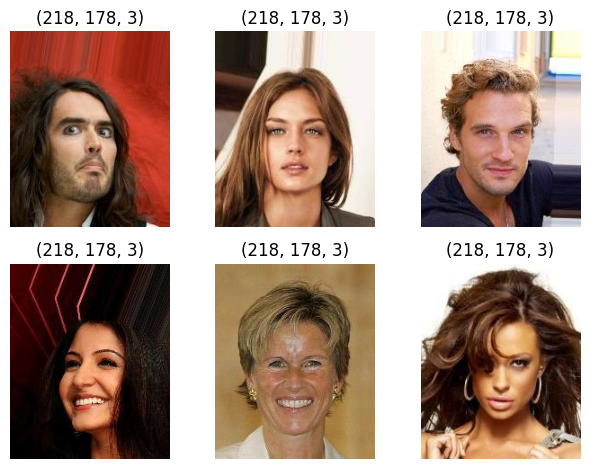

In [18]:
# Display Multiple Sample Images.
for i in range(0, 6):
    plt.subplot(2, 3, i+1)

    # Read an Image.
    img = cv2.imread(IMG_PATH + '/' + df["image_id"][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display Image.
    plt.imshow(img)
    plt.title(img.shape)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Get the category distribution.
category_count = df["Gender"].value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

Gender
Female    12760
Male       9240
Name: count, dtype: int64


In [20]:
# Get the indices of the higher category indices images.
np.random.seed(42)
indices = df[df["Gender"] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Drop the extra rows of female images to fix class imbalance problem.
drop_sample = np.random.choice(indices, sample_size, replace = False)
df = df.drop(drop_sample, axis = "index")

<ipython-input-20-6b82c4730800>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_size = category_count[0] - category_count[1]


<Axes: xlabel='Gender'>

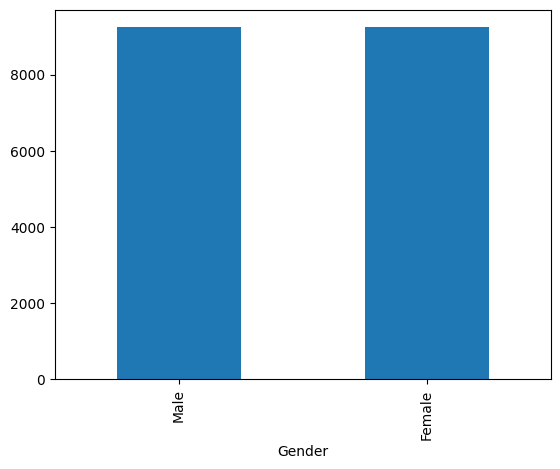

In [21]:
df["Gender"].value_counts().plot.bar()

In [22]:
train_df, test_df = train_test_split(df, test_size=0.2)
test_df, validation_df = train_test_split(test_df, test_size=0.33)

In [23]:
print("Total Train Sample Images : ", len(train_df))
print("Total Test Sample Images : ", len(test_df))
print("Total Validation Sample Images : ", len(validation_df))

Total Train Sample Images :  14784
Total Test Sample Images :  2476
Total Validation Sample Images :  1220


In [24]:
IMAGE_SIZE = (218, 178)
BATCH_SIZE = 128

In [25]:
# Generate Train Images Data Generator.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)
# Generate Validation Images Data Generator.
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 14784 validated image filenames belonging to 2 classes.
Found 1220 validated image filenames belonging to 2 classes.


In [26]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2476 validated image filenames.


In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [28]:
from tensorflow.keras.applications import VGG16

# Inisialisasi model VGG16
base_vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))

# Unfreeze 5 layer terakhir
for layer in base_vgg_model.layers[-5:]:
    layer.trainable = True  # Mengatur layer terakhir agar bisa dilatih


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Membuat Arsitektur Fully Connected dengan VGG16
vgg_model = Sequential([
    base_vgg_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2, activation="softmax")
])

# Kompile Model Deep Learning
base_learning_rate = 0.00001
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Ubah dari True menjadi False
    metrics=['accuracy']
)


In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
earlystop = EarlyStopping(patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=4,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.001)
callbacks = [earlystop, learning_rate_reduction]


In [31]:
# Training Model
history = vgg_model.fit(
    train_generator,
    validation_data=validation_generator,
    validation_steps=len(validation_df) // BATCH_SIZE,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    epochs=5,
    verbose=2,
    callbacks=callbacks
)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 - 397s - 3s/step - accuracy: 0.8019 - loss: 0.4176 - val_accuracy: 0.9358 - val_loss: 0.1805 - learning_rate: 1.0000e-05
Epoch 2/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


115/115 - 48s - 415ms/step - accuracy: 0.8828 - loss: 0.3258 - val_accuracy: 0.9559 - val_loss: 0.1174 - learning_rate: 1.0000e-05
Epoch 3/5
115/115 - 221s - 2s/step - accuracy: 0.9232 - loss: 0.2110 - val_accuracy: 0.9410 - val_loss: 0.1764 - learning_rate: 1.0000e-05
Epoch 4/5
115/115 - 2s - 16ms/step - accuracy: 0.9531 - loss: 0.1661 - val_accuracy: 0.9412 - val_loss: 0.1575 - learning_rate: 1.0000e-05
Epoch 5/5
115/115 - 214s - 2s/step - accuracy: 0.9439 - loss: 0.1607 - val_accuracy: 0.9523 - val_loss: 0.1328 - learning_rate: 1.0000e-05


In [32]:
# Menampilkan Ringkasan Model VGG16
vgg_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 6, 5, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,562,984 (177.62 MB)

 Trainable params: 15,520,994 (59.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,041,990 (118.42 MB)

In [33]:
predict = vgg_model.predict(test_generator, steps=int(np.ceil(len(test_df) / BATCH_SIZE)))


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


In [34]:
prediction = predict.argmax(axis=-1)
test_df['Prediction'] = ["Male" if ele == 1 else "Female" for ele in prediction]

In [35]:
print(train_df['Gender'].value_counts())


Gender
Male      7411
Female    7373
Name: count, dtype: int64


In [36]:
test_df

,image_id,Gender,Prediction
4141,146642.jpg,Female,Female
6115,065735.jpg,Male,Male
17786,116578.jpg,Female,Female
1423,062557.jpg,Female,Female
7917,048427.jpg,Male,Male
...,...,...,...
2728,057113.jpg,Female,Female
9648,141490.jpg,Female,Female
18854,090446.jpg,Male,Male
9628,164346.jpg,Male,Male


In [37]:
labels = ['Male','Female']

cm = confusion_matrix(test_df['Gender'], test_df["Prediction"], labels= labels)
cm

array([[1200,   11],
       [ 108, 1157]])

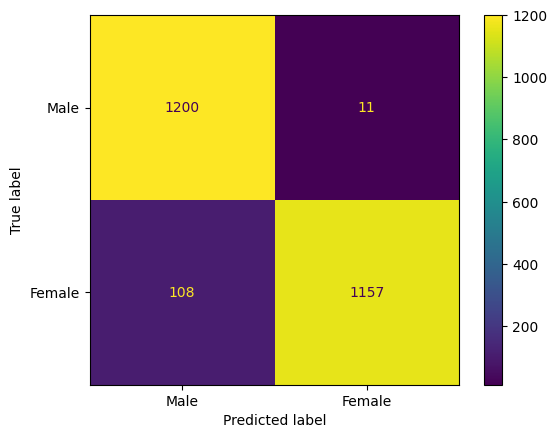

In [38]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

In [39]:
# Matriks Evaluasi

# Menghitung matriks confusion -> pada object 'cm_1' di atas

# Membuat laporan klasifikasi
target_names = ['Male', 'Female']  # Ganti dengan nama kelas yang sesuai
classification_rep = classification_report(test_df['Gender'], test_df['Prediction'],
                                            target_names=target_names, output_dict=True)

# Membuat DataFrame dari matriks confusion
df_confusion = pd.DataFrame(cm, columns=target_names, index=target_names)

# Membuat DataFrame dari laporan klasifikasi
df_classification = pd.DataFrame(classification_rep).transpose()

# Menampilkan tabel matriks evaluasi
print("Confusion Matrix:")
print(df_confusion)
print("\nClassification Report:")
print(df_classification)

# Code Modif from Chat GPT

Confusion Matrix:
        Male  Female
Male    1200      11
Female   108    1157

Classification Report:
              precision    recall  f1-score      support
Male           0.990582  0.914625  0.951089  1265.000000
Female         0.917431  0.990917  0.952759  1211.000000
accuracy       0.951939  0.951939  0.951939     0.951939
macro avg      0.954007  0.952771  0.951924  2476.000000
weighted avg   0.954804  0.951939  0.951906  2476.000000


In [40]:
# Matrix Evaluasi
print(classification_report(test_df['Gender'], test_df['Prediction'], target_names = ['Male', 'Female']))


              precision    recall  f1-score   support

        Male       0.99      0.91      0.95      1265
      Female       0.92      0.99      0.95      1211

    accuracy                           0.95      2476
   macro avg       0.95      0.95      0.95      2476
weighted avg       0.95      0.95      0.95      2476



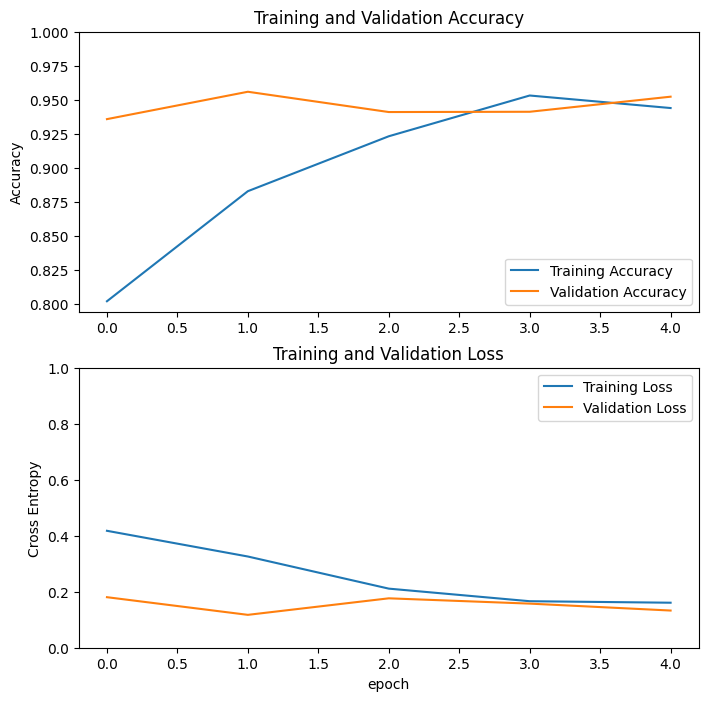

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
# Menyiapkan Data yang Salah Prediksi
wrong_df = test_df[test_df['Gender'] != test_df['Prediction']]

# menyiapkan Data yang Male di Prediksi sebagai Female
wrong_woman_df = wrong_df[wrong_df['Gender'] == 'Male']
wrong_woman_df.head()

,image_id,Gender,Prediction
6247,118933.jpg,Male,Female
6848,099392.jpg,Male,Female
8443,172656.jpg,Male,Female
12777,047175.jpg,Male,Female
19600,063431.jpg,Male,Female


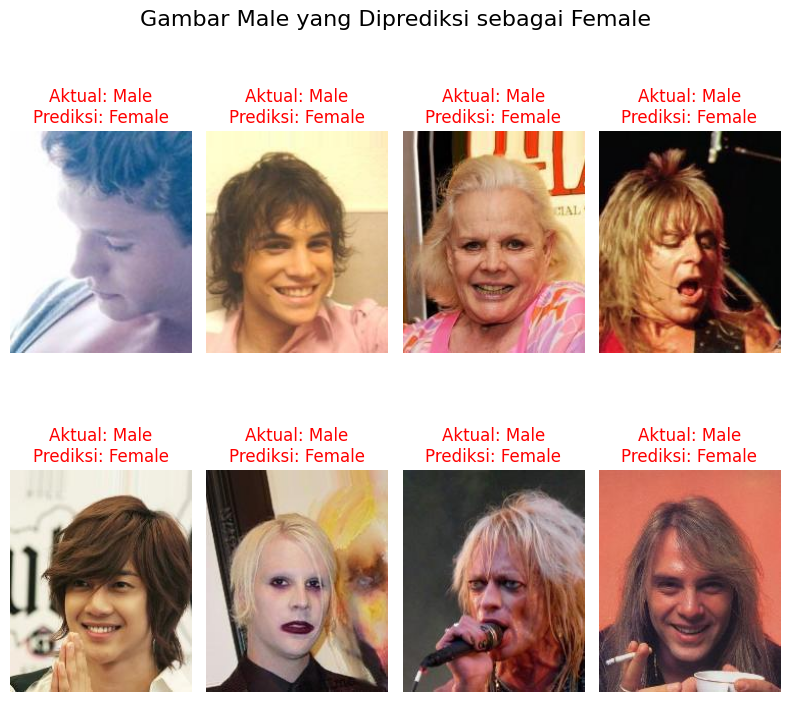

In [43]:
import os
import matplotlib.pyplot as plt

# Create a subplot with 3 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(8, 8))

# Iterate over the data frame subset and subplot axes
for index, (_, row) in enumerate(wrong_woman_df.iterrows()):
    if index >= len(axes.flatten()):
        break

    ax = axes.flatten()[index]

    # Get the image file name and corresponding values
    image_file = row['image_id']
    actual_gender = row['Gender']
    predicted_gender = row['Prediction']

    # Read and plot the image
    image_path = os.path.join(IMG_PATH, image_file)
    image = plt.imread(image_path)
    ax.imshow(image)

    # Menambahkan judul dengan warna merah jika prediksi salah
    title_color = 'red' if predicted_gender != actual_gender else 'green'
    ax.set_title(f'Aktual: {actual_gender}\nPrediksi: {predicted_gender}', color=title_color)

    # Remove the axis ticks and labels
    ax.axis('off')

# Menambahkan judul keseluruhan di luar loop
plt.suptitle("Gambar Male yang Diprediksi sebagai Female", size=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()


In [44]:
# Menyiapkan Data yang Salah Prediksi
wrong_df = test_df[test_df['Gender'] != test_df['Prediction']]

# menyiapkan Data yang Male di Prediksi sebagai Female
wrong_male_df = wrong_df[wrong_df['Gender'] == 'Female']
wrong_male_df.head()

,image_id,Gender,Prediction
1606,181224.jpg,Female,Male
6325,068006.jpg,Female,Male
4190,067430.jpg,Female,Male
14012,049683.jpg,Female,Male
16608,061894.jpg,Female,Male


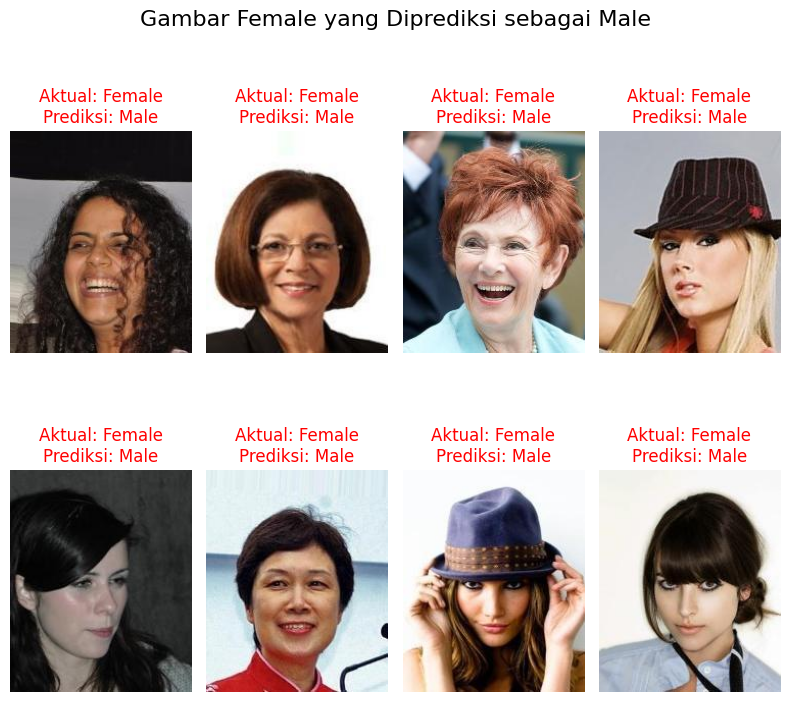

In [45]:
import os
import matplotlib.pyplot as plt

# Create a subplot with 3 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(8, 8))

# Iterate over the data frame subset and subplot axes
for index, (_, row) in enumerate(wrong_male_df.iterrows()):
    if index >= len(axes.flatten()):
        break

    ax = axes.flatten()[index]

    # Get the image file name and corresponding values
    image_file = row['image_id']
    actual_gender = row['Gender']
    predicted_gender = row['Prediction']

    # Read and plot the image
    image_path = os.path.join(IMG_PATH, image_file)
    image = plt.imread(image_path)
    ax.imshow(image)

    # Menambahkan judul dengan warna merah jika prediksi salah
    title_color = 'red' if predicted_gender != actual_gender else 'green'
    ax.set_title(f'Aktual: {actual_gender}\nPrediksi: {predicted_gender}', color=title_color)

    # Remove the axis ticks and labels
    ax.axis('off')

# Menambahkan judul keseluruhan di luar loop
plt.suptitle("Gambar Female yang Diprediksi sebagai Male", size=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()


In [46]:
gender_target = {0: 'Female', 1: 'Male'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)

    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)

    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()


def display_result(filename, prediction, target):
    '''
    Display the results in HTML

    '''

    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"

    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'

    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3> <br>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p> <br><br>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               ,  gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [47]:
def gender_prediction(filename):
    '''
    predict the gender

    input:
        filename: str of the file name

    return:
        array of the prob of the targets.

    '''

    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)

    # prediction
    result = vgg_model.predict(im)
    prediction = np.argmax(result)

    return result

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step



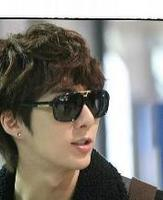

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



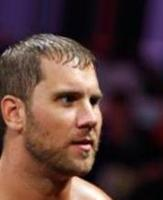

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



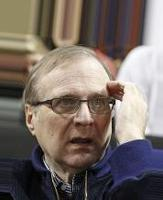

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



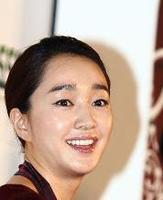

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



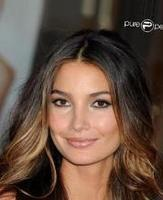

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



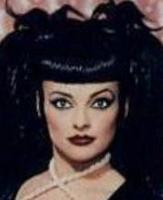

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



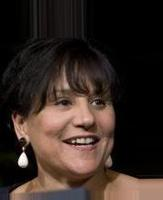

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



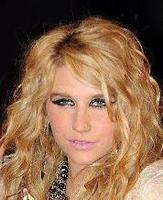

In [48]:
df_to_test = DF_PARTITION[(DF_PARTITION['partition'] == 2)].sample(8)

for index, target in df_to_test.iterrows():
    result = gender_prediction(IMG_PATH + index)

    #display result
    display_result(IMG_PATH + index, result[0], target['Male'])

# Deep Learning Celeb A

Sumber dataset Celeb A [link text](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)